In [3]:
# Installing the PyMC Marketing library
!pip install pymc_marketing

In [4]:
!pip install openpyxl

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from fastprogress.fastprogress import progress_bar
from lifetimes import BetaGeoFitter

from pymc_marketing import clv

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Data Loading and Preprocessing

In [2]:
data = pd.read_csv('/Users/changyu/Downloads/manifest.csv')
print(data.shape)
data.head()


(4762028, 3)


,customer_id,consume_num,create_time
0,27226,60.0,2019-10-23 15:22:52
1,33376,30.0,2019-10-18 17:27:37
2,28924,30.0,2019-10-15 11:00:34
3,6889,30.0,2019-10-16 13:49:03
4,9720,30.0,2019-10-25 10:56:06


#### ## RFM-T Format
We will use the BG/NBD model to infer the frequency of repeat purchases for all customers in the dataset.

* `frequency` represents the number of _repeat_ purchases that a customer has made, i.e. one less than the total number of purchases;
* `T` represents a customer's "age", i.e. the duration between a customer's first purchase and the end of the period of study. In this example notebook, the units of time are in weeks;
* `recency` represents the timepoint when a customer made their most recent purchase. This is also equal to the duration between a customer’s first non-repeat purchase (usually time 0) and last purchase. If a customer has made only 1 purchase, their recency is 0;
* `monetary_value` represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases.

In [22]:
data_summary_rfm = clv.utils.rfm_summary(data, 'customer_id', 'create_time', 'consume_num')
data_bg = data_summary_rfm.query("frequency > 1")
data_bg.head()

,customer_id,frequency,recency,T,monetary_value
0,4889,225.0,1890.0,2046.0,61.044444
2,4920,295.0,2039.0,2047.0,63.322034
3,4952,1386.0,1745.0,1746.0,275.937951
5,4967,39.0,1274.0,1276.0,81.410256
6,4979,832.0,2160.0,2162.0,62.391827


In [8]:
data_gg = data_summary_rfm.query("monetary_value > 0")
data_gg.head()

,customer_id,frequency,recency,T,monetary_value
0,4889,225.0,1890.0,2046.0,61.044444
2,4920,295.0,2039.0,2047.0,63.322034
3,4952,1386.0,1745.0,1746.0,275.937951
5,4967,39.0,1274.0,1276.0,81.410256
6,4979,832.0,2160.0,2162.0,62.391827


## BG/NBD Model

In [23]:
model = clv.BetaGeoModel(data=data_bg)
model.build_model()

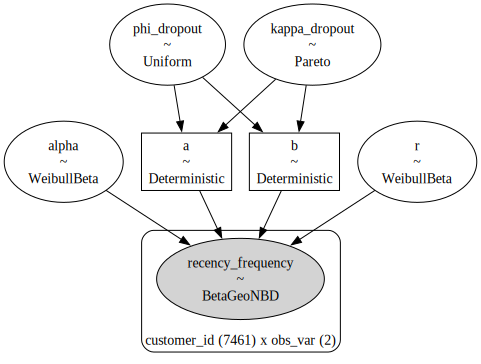

In [24]:
model.graphviz()

In [25]:
model_config = {
    'a_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
    'b_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
    'alpha_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
    'r_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
}

# Rebuilding the model with updated prior configurations.
model = clv.BetaGeoModel(
    data = data_bg,
    model_config = model_config,
)
model.build_model()

sample_kwargs = {
    "draws": 2_000,
    "chains": 4,
    "target_accept": 0.9,
    "random_seed": 42,
}
idata_mcmc = model.fit(**sample_kwargs)
idata_mcmc

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, a, b, r]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 92 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data

In [27]:
model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.498,0.089,4.324,4.659,0.001,0.001,4568.0,4885.0,1.0
a,0.119,0.004,0.110,0.127,0.000,0.000,4916.0,4298.0,1.0
b,8.863,0.712,7.591,10.243,0.010,0.008,4931.0,4794.0,1.0
r,0.767,0.011,0.744,0.786,0.000,0.000,4676.0,4875.0,1.0


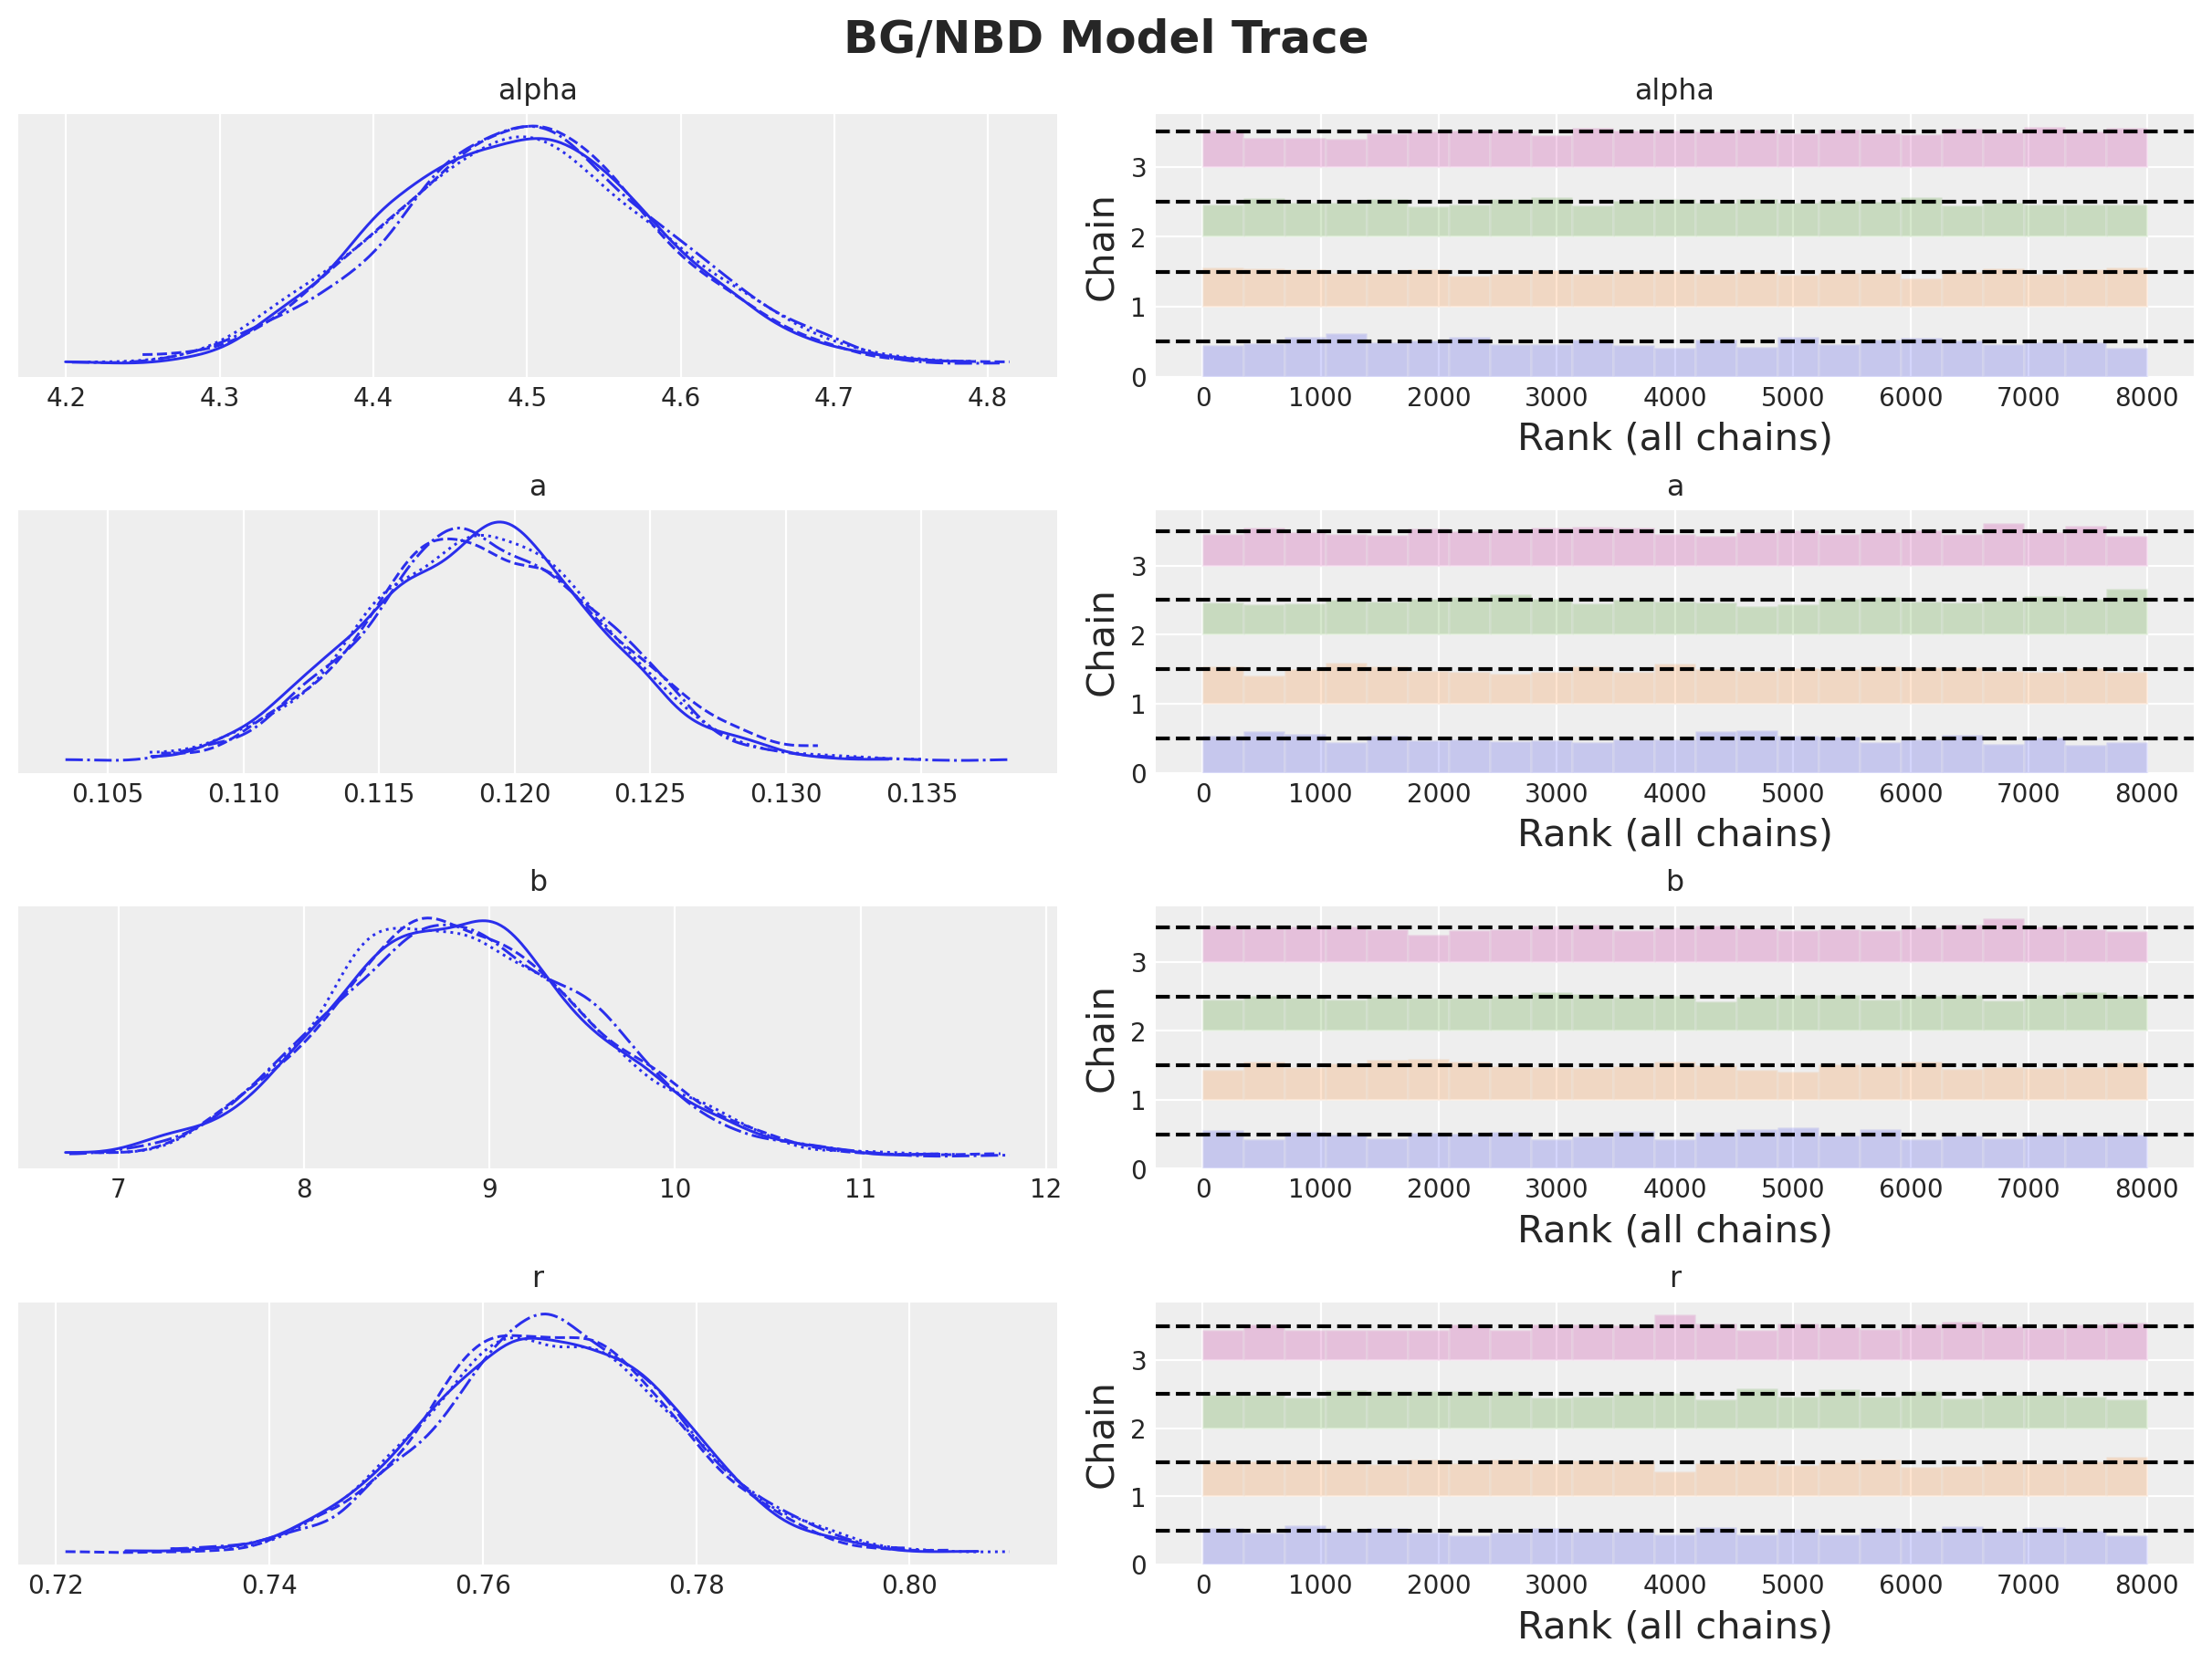

In [28]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("BG/NBD Model Trace", fontsize=18, fontweight="bold");

In [29]:
model_map = clv.BetaGeoModel(data=data_bg)
idata_map = model_map.fit(method="map")

Output()

In [30]:
idata_map
map_summary = model_map.fit_summary()

map_summary

alpha            4.495
phi_dropout      0.013
kappa_dropout    8.763
r                0.766
a                0.118
b                8.645
Name: value, dtype: float64

In [31]:
bgf = BetaGeoFitter()
bgf.fit(
    frequency=data_bg["frequency"].values,
    recency=data_bg["recency"].values,
    T=data_bg["T"].values,
)

bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.766216,0.011104,0.744452,0.787980
alpha,4.494206,0.088495,4.320757,4.667656
a,0.118405,0.004315,0.109947,0.126862
b,8.753501,0.697807,7.385798,10.121204


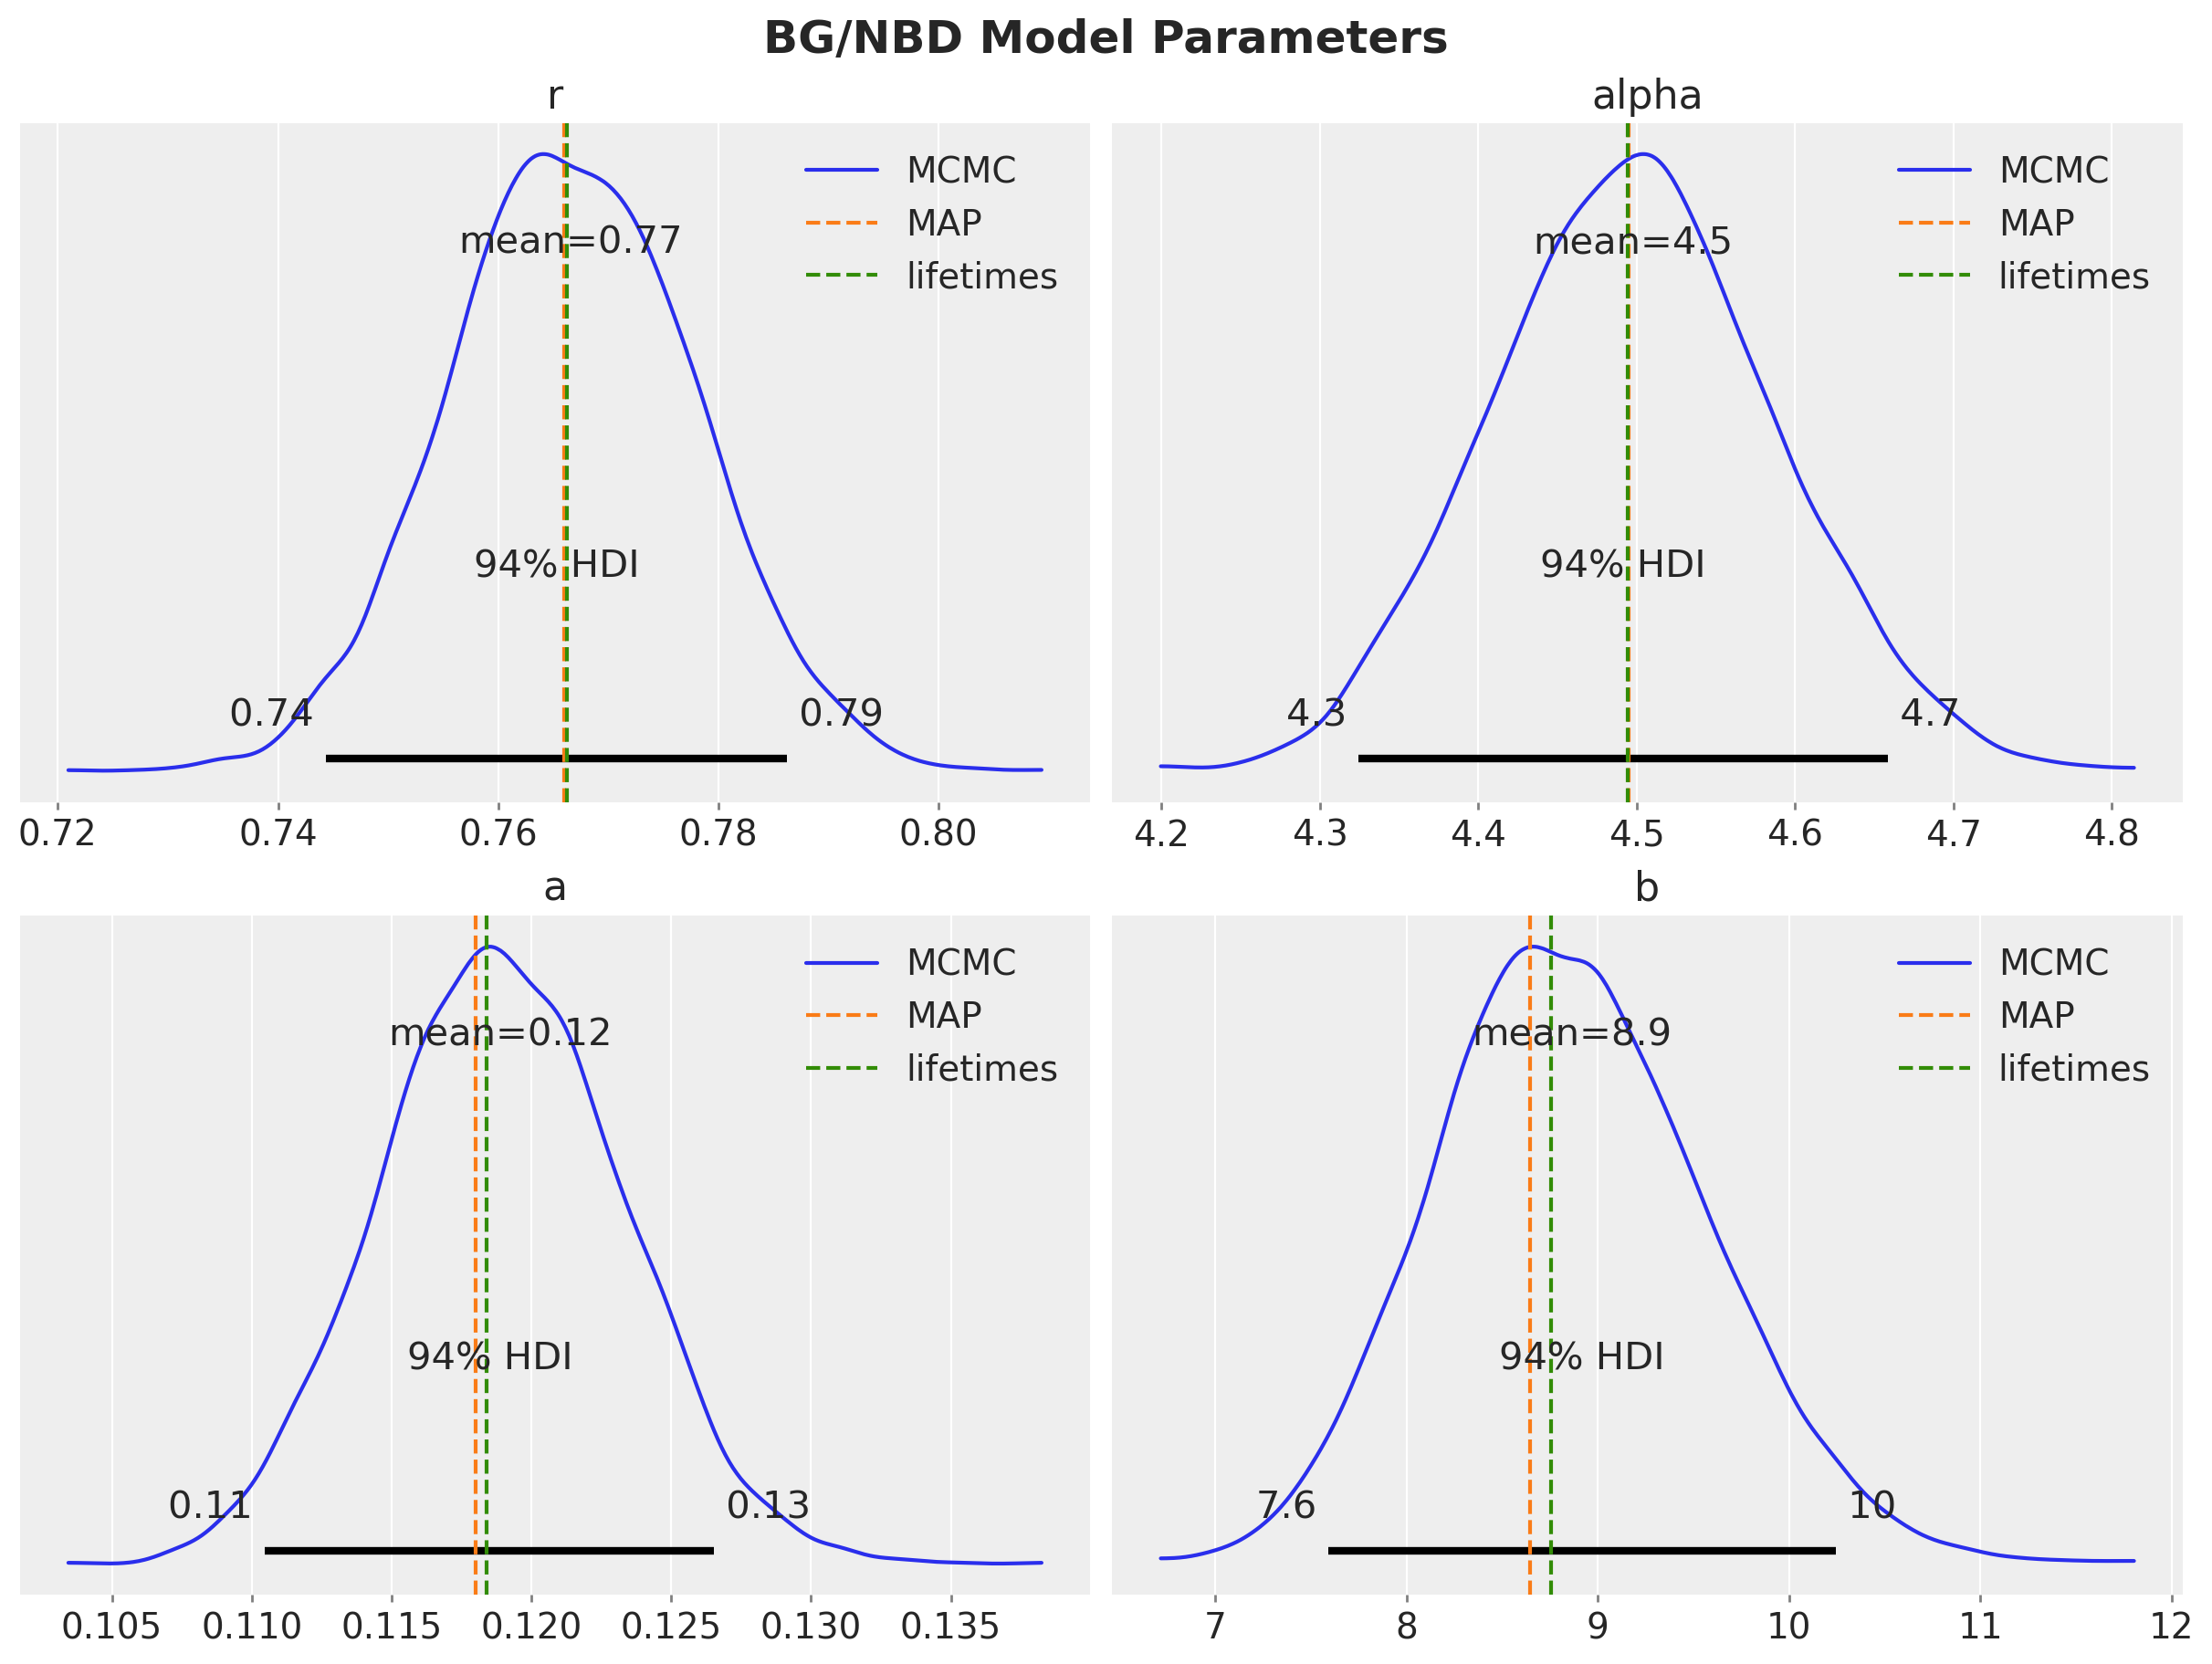

In [32]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 9), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for i, var_name in enumerate(["r", "alpha", "a", "b"]):
    ax = axes[i]
    az.plot_posterior(
        model.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        ax=ax,
        label="MCMC",
    )
    ax.axvline(x=map_summary[var_name], color="C1", linestyle="--", label="MAP")
    ax.axvline(
        x=bgf.summary["coef"][var_name], color="C2", linestyle="--", label="lifetimes"
    )
    ax.legend(loc="upper right")
    ax.set_title(var_name)

plt.gcf().suptitle("BG/NBD Model Parameters", fontsize=18, fontweight="bold");

Sampling: [a, alpha, b, r, recency_frequency]


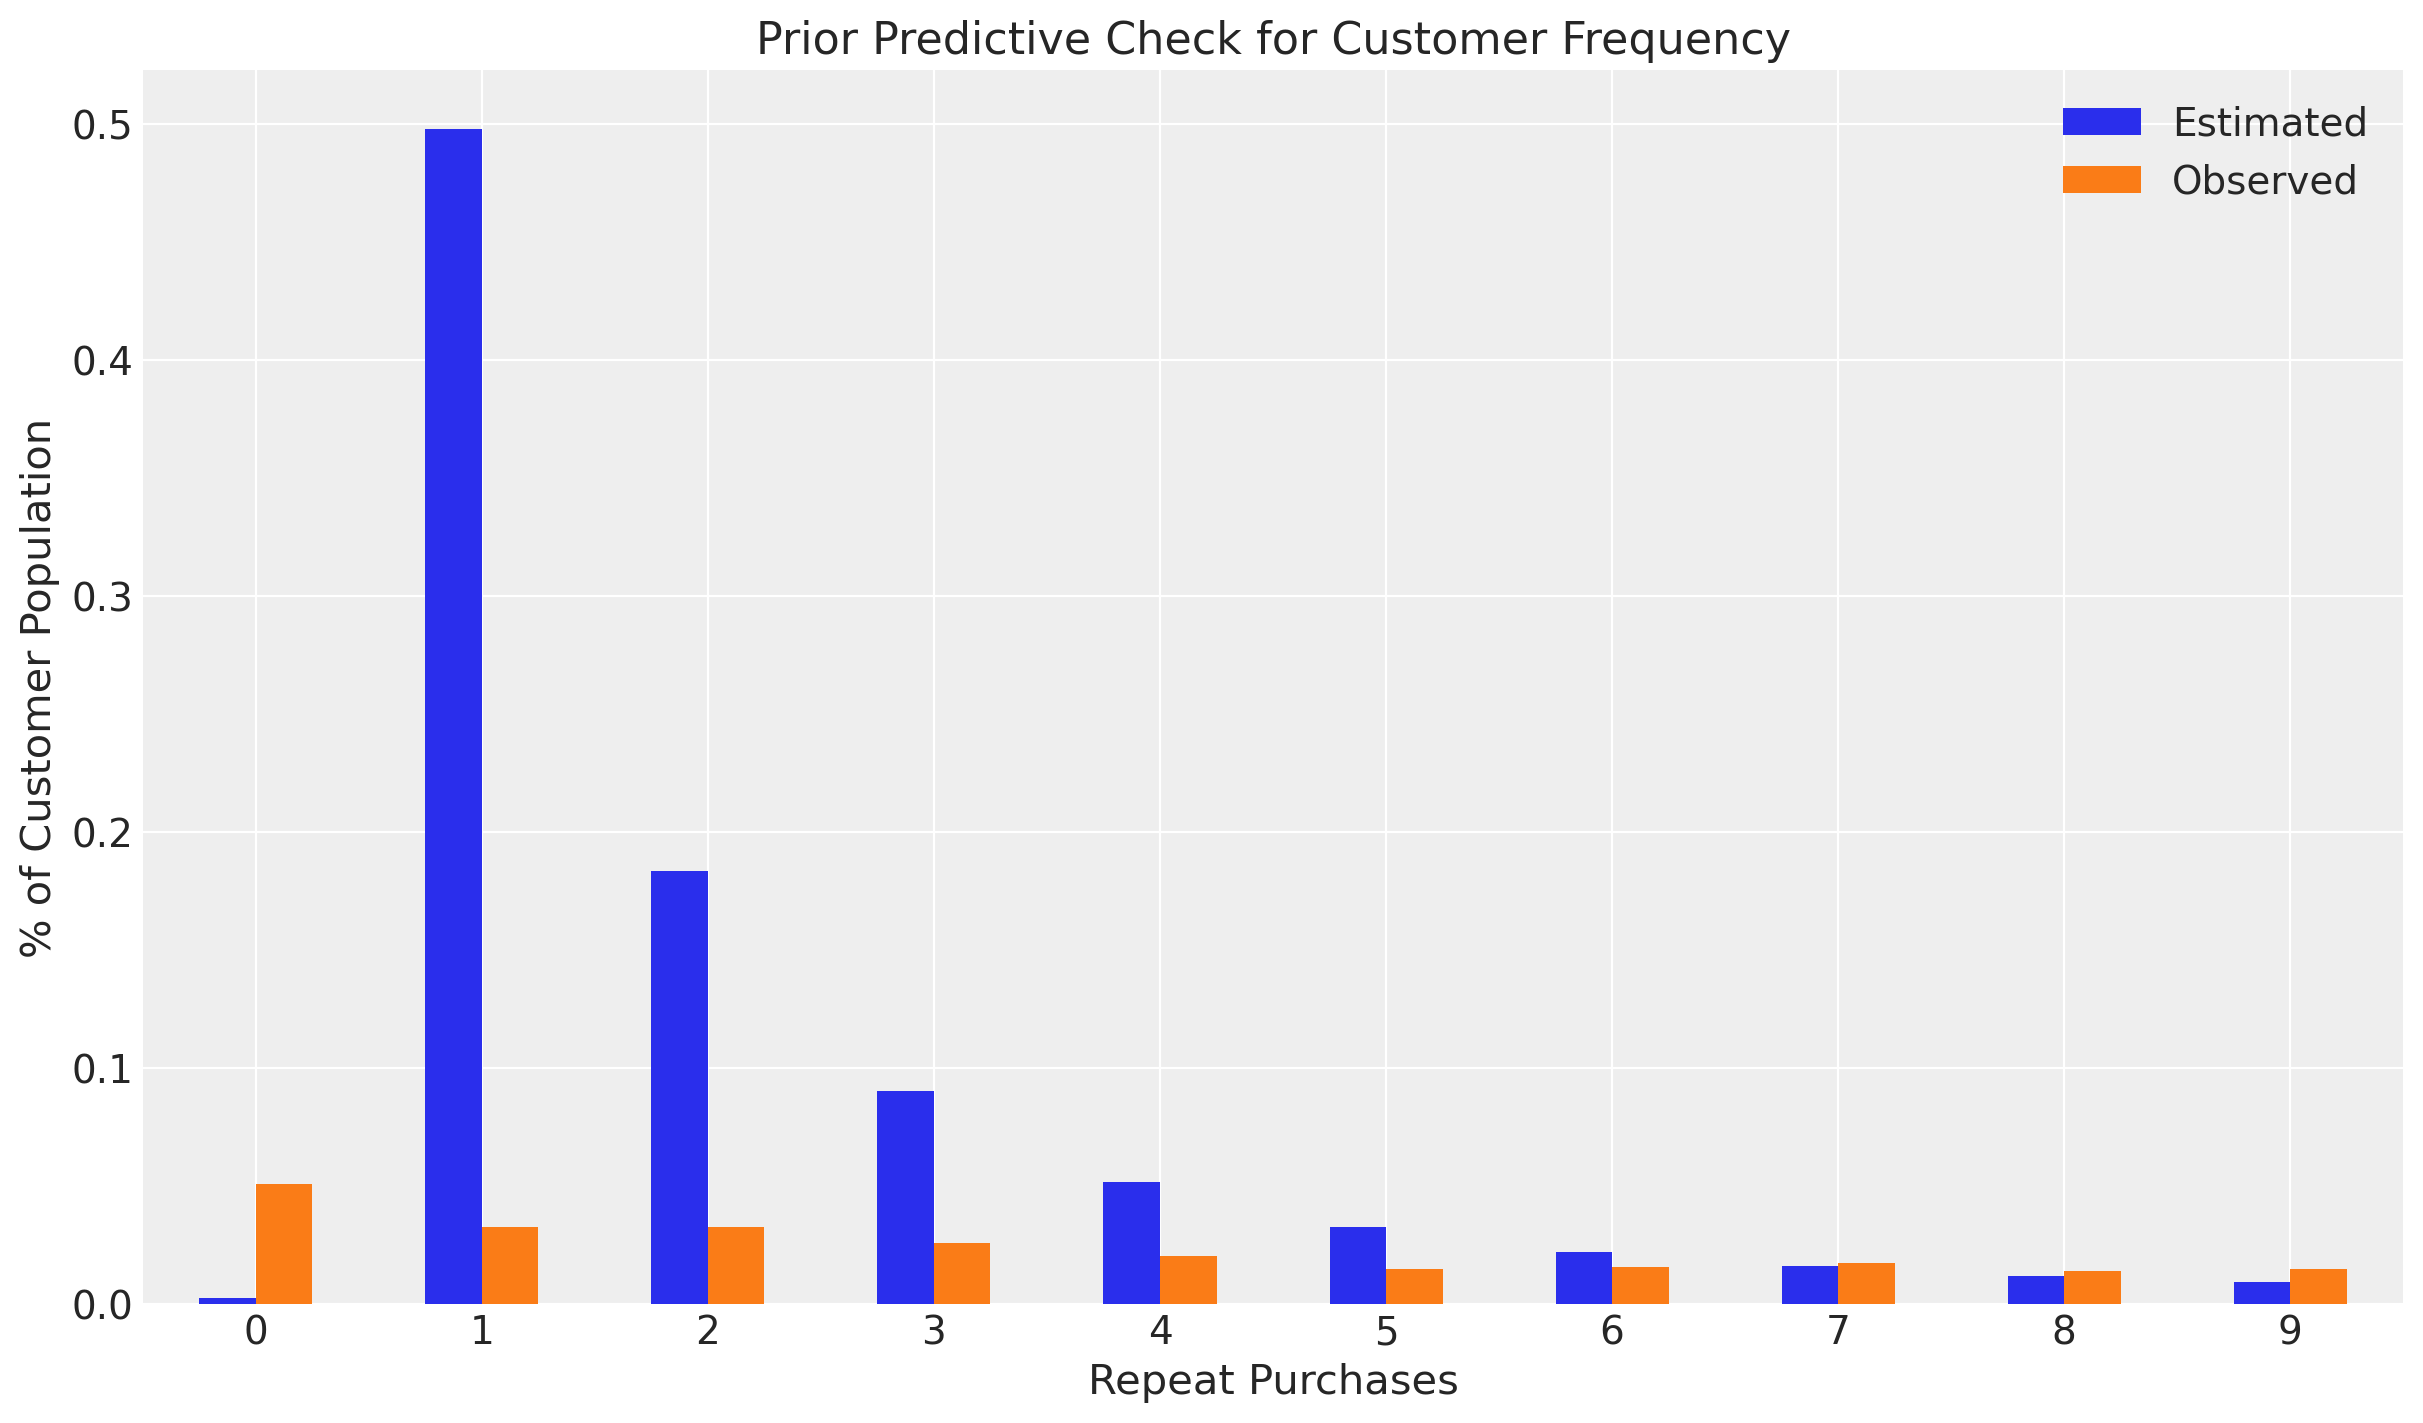

In [33]:
clv.plot_expected_purchases_ppc(model, ppc="prior");

In [ ]:
clv.plot_expected_purchases_ppc(model, ppc="posterior");

Sampling: [recency_frequency]


Output()

In [22]:
example_customer_ids = [1364781544796422146, 33485, 35036, 33475, 4987, 5039]

data_small = data_summary_rfm.query("customer_id.isin(@example_customer_ids)")

data_small.head(6)

,customer_id,frequency,recency,T,monetary_value
7,4987,884.0,1683.0,1909.0,74.802036
9,5039,4.0,630.0,1243.0,30.000000
639,33475,945.0,2098.0,2098.0,120.121693
640,33485,1786.0,2093.0,2093.0,402.525196
722,35036,1060.0,1344.0,2059.0,427.688679
2967,1364781544796422146,1192.0,1376.0,1376.0,1693.431208


In [27]:
steps = 90

expected_num_purchases_steps = xr.concat(
    objs=[
        model.expected_purchases(
            data=data_small,
            future_t=t,
        )
        for t in progress_bar(range(steps))
    ],
    dim="t",
).transpose(..., "t")

### Predicting purchase behavior of a new customer

We can use the fitted model to predict the number of purchases for a fresh new customer.

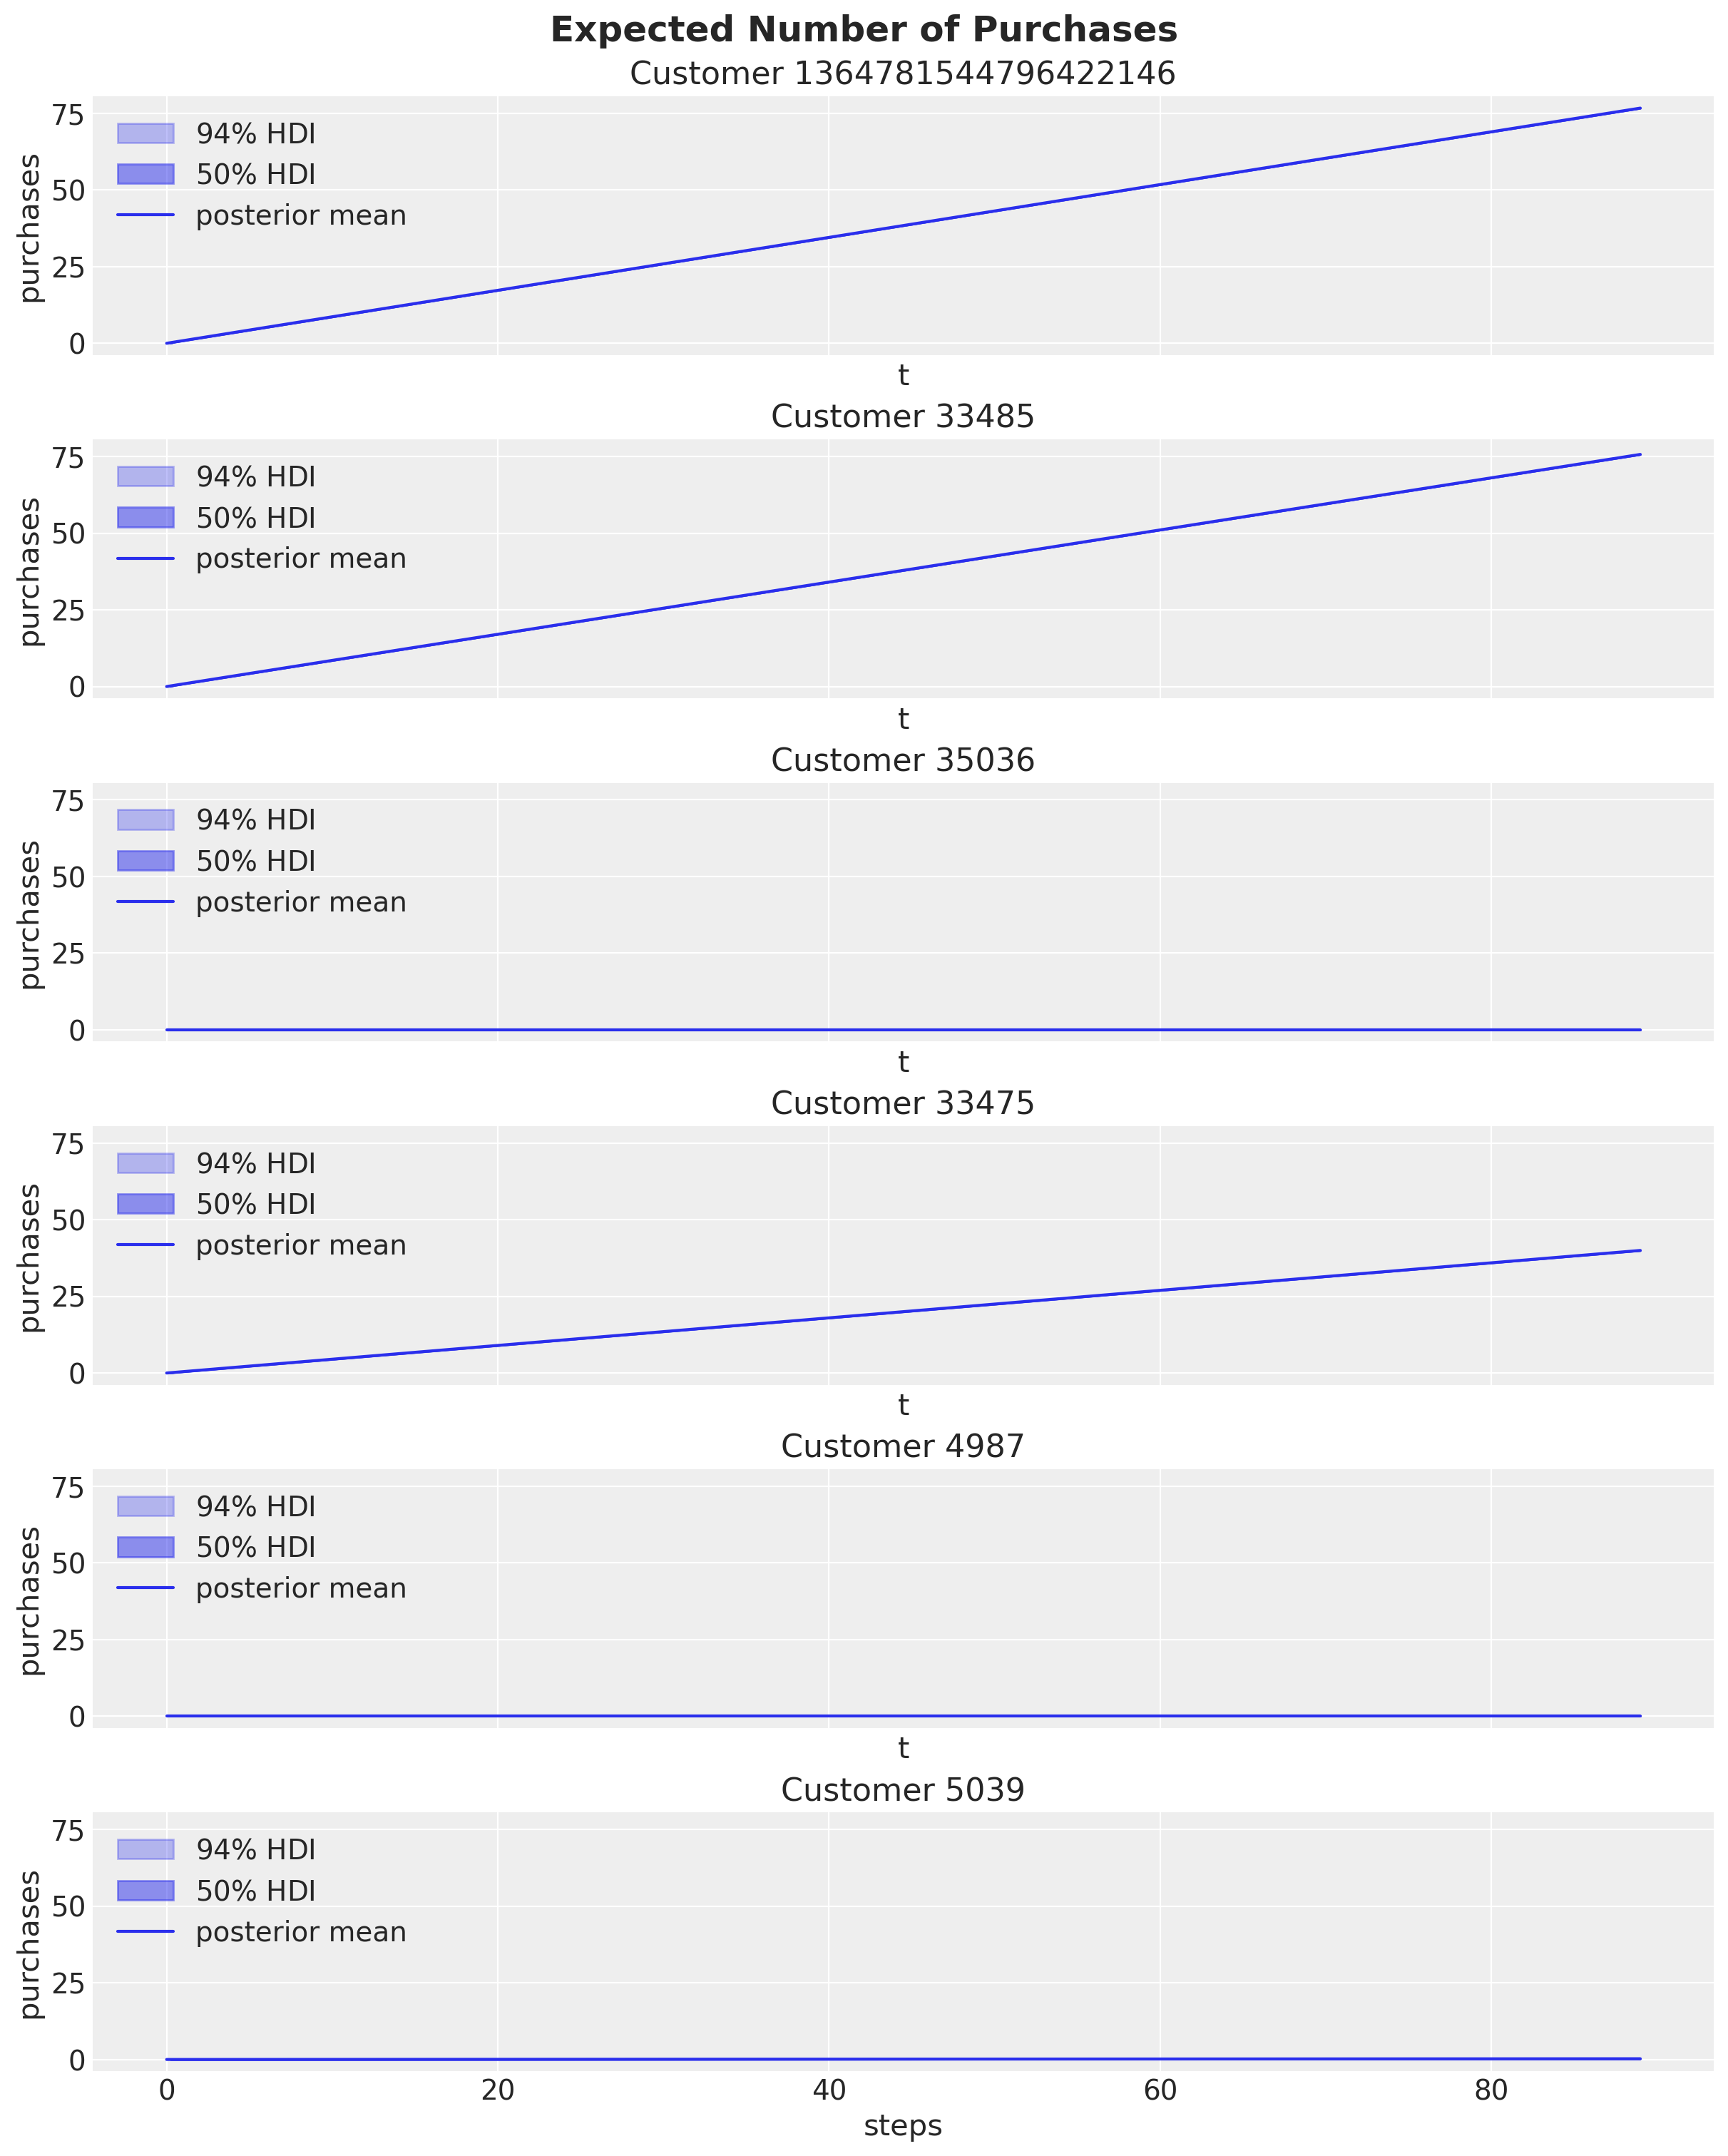

In [28]:
fig, axes = plt.subplots(
    nrows=len(example_customer_ids),
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    customer_expected_num_purchases_steps = expected_num_purchases_steps.sel(
        customer_id=customer_id
    )
    az.plot_hdi(
        range(steps),
        customer_expected_num_purchases_steps,
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        range(steps),
        customer_expected_num_purchases_steps,
        hdi_prob=0.5,
        color="C0",
        fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
        ax=ax,
    )
    ax.plot(
        range(steps),
        customer_expected_num_purchases_steps.mean(dim=("chain", "draw")),
        color="C0",
        label="posterior mean",
    )
    ax.legend(loc="upper left")
    ax.set(title=f"Customer {customer_id}", xlabel="t", ylabel="purchases")

axes[-1].set(xlabel="steps")
plt.gcf().suptitle("Expected Number of Purchases", fontsize=18, fontweight="bold");

In [29]:
steps = 90

future_alive_all = []

for t in progress_bar(range(steps)):
    future_data = data_small.copy()
    future_data["T"] = future_data["T"] + t
    future_alive = model.expected_probability_alive(data=future_data)
    future_alive_all.append(future_alive)

expected_probability_alive_steps = xr.concat(
    objs=future_alive_all,
    dim="t",
).transpose(..., "t")

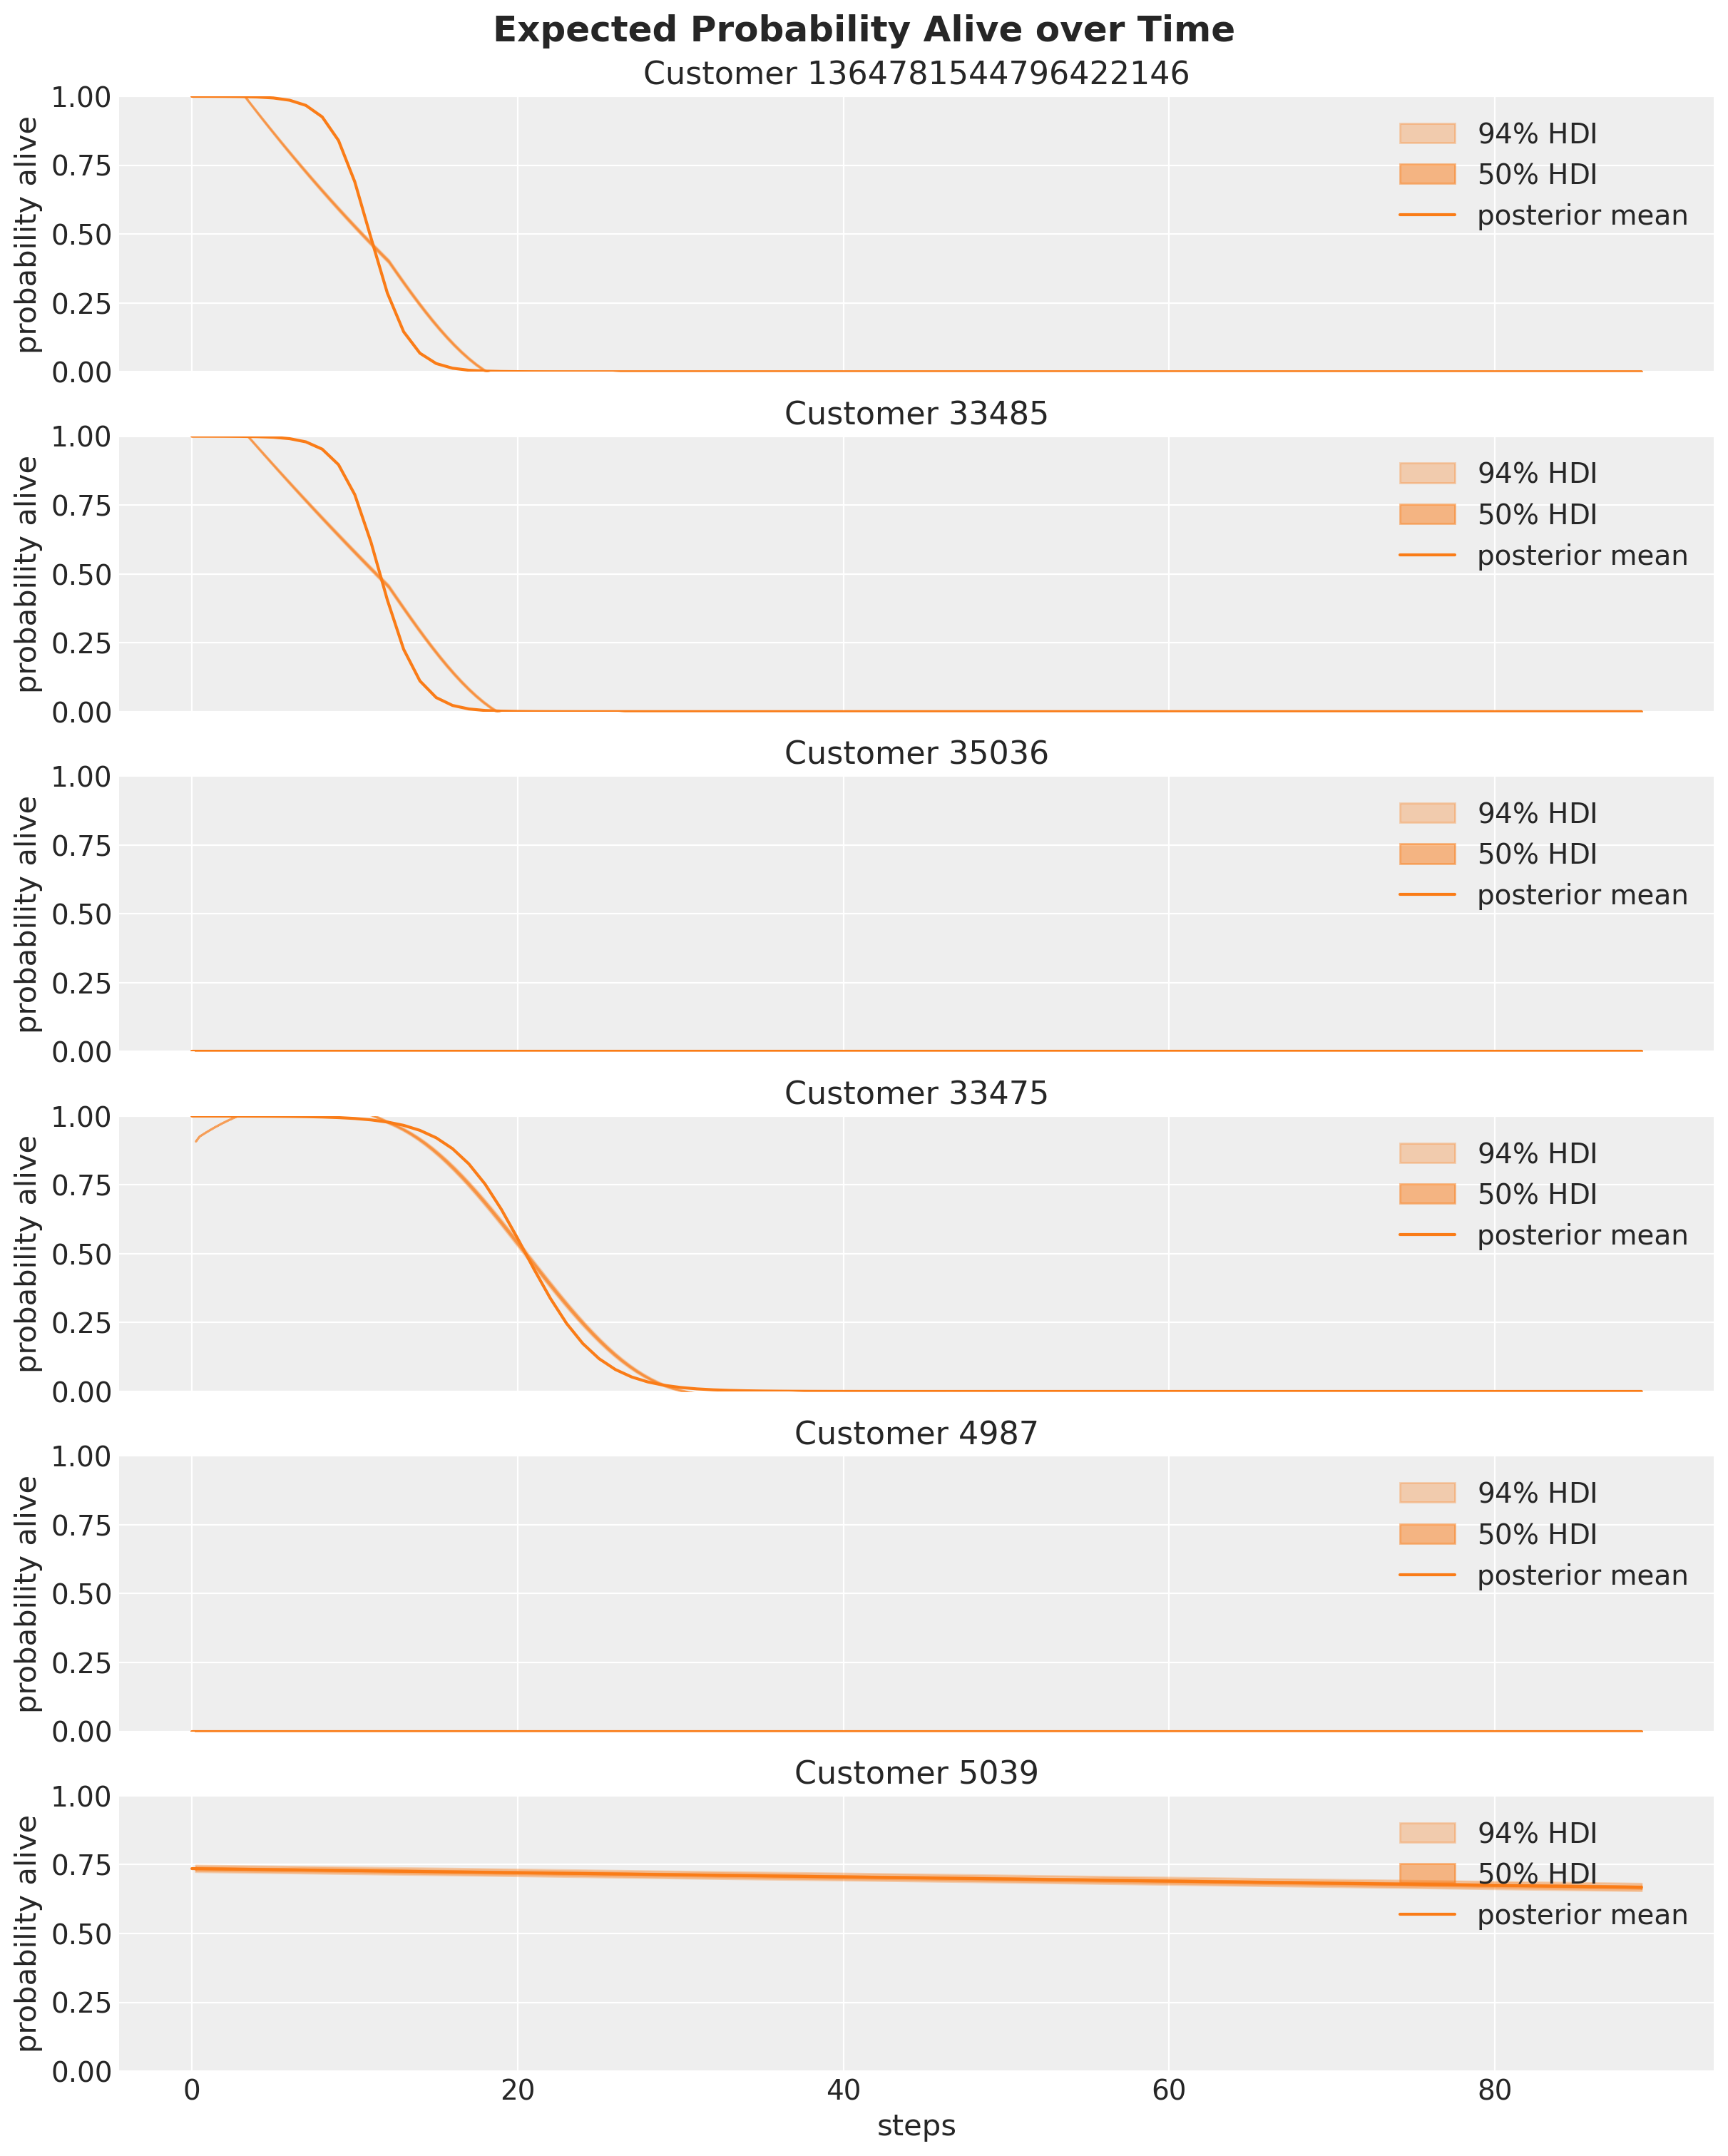

In [30]:
fig, axes = plt.subplots(
    nrows=len(example_customer_ids),
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    customer_expected_probability_alive_steps = expected_probability_alive_steps.sel(
        customer_id=customer_id
    )
    az.plot_hdi(
        range(steps),
        customer_expected_probability_alive_steps,
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        range(steps),
        customer_expected_probability_alive_steps,
        hdi_prob=0.5,
        color="C1",
        fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
        ax=ax,
    )
    ax.plot(
        range(steps),
        customer_expected_probability_alive_steps.mean(dim=("chain", "draw")),
        color="C1",
        label="posterior mean",
    )
    ax.legend(loc="upper right")
    ax.set(title=f"Customer {customer_id}", ylabel="probability alive", ylim=(0, 1))

axes[-1].set(xlabel="steps")
plt.gcf().suptitle(
    "Expected Probability Alive over Time", fontsize=18, fontweight="bold"
);

In [23]:
steps = 30
expected_probability_zero_purchases = xr.concat(
    objs=[
        model.expected_probability_no_purchase(
            data=data_small,
            t=t,
        )
        for t in progress_bar(range(steps))
    ],
    dim="t",
).transpose(..., "t")

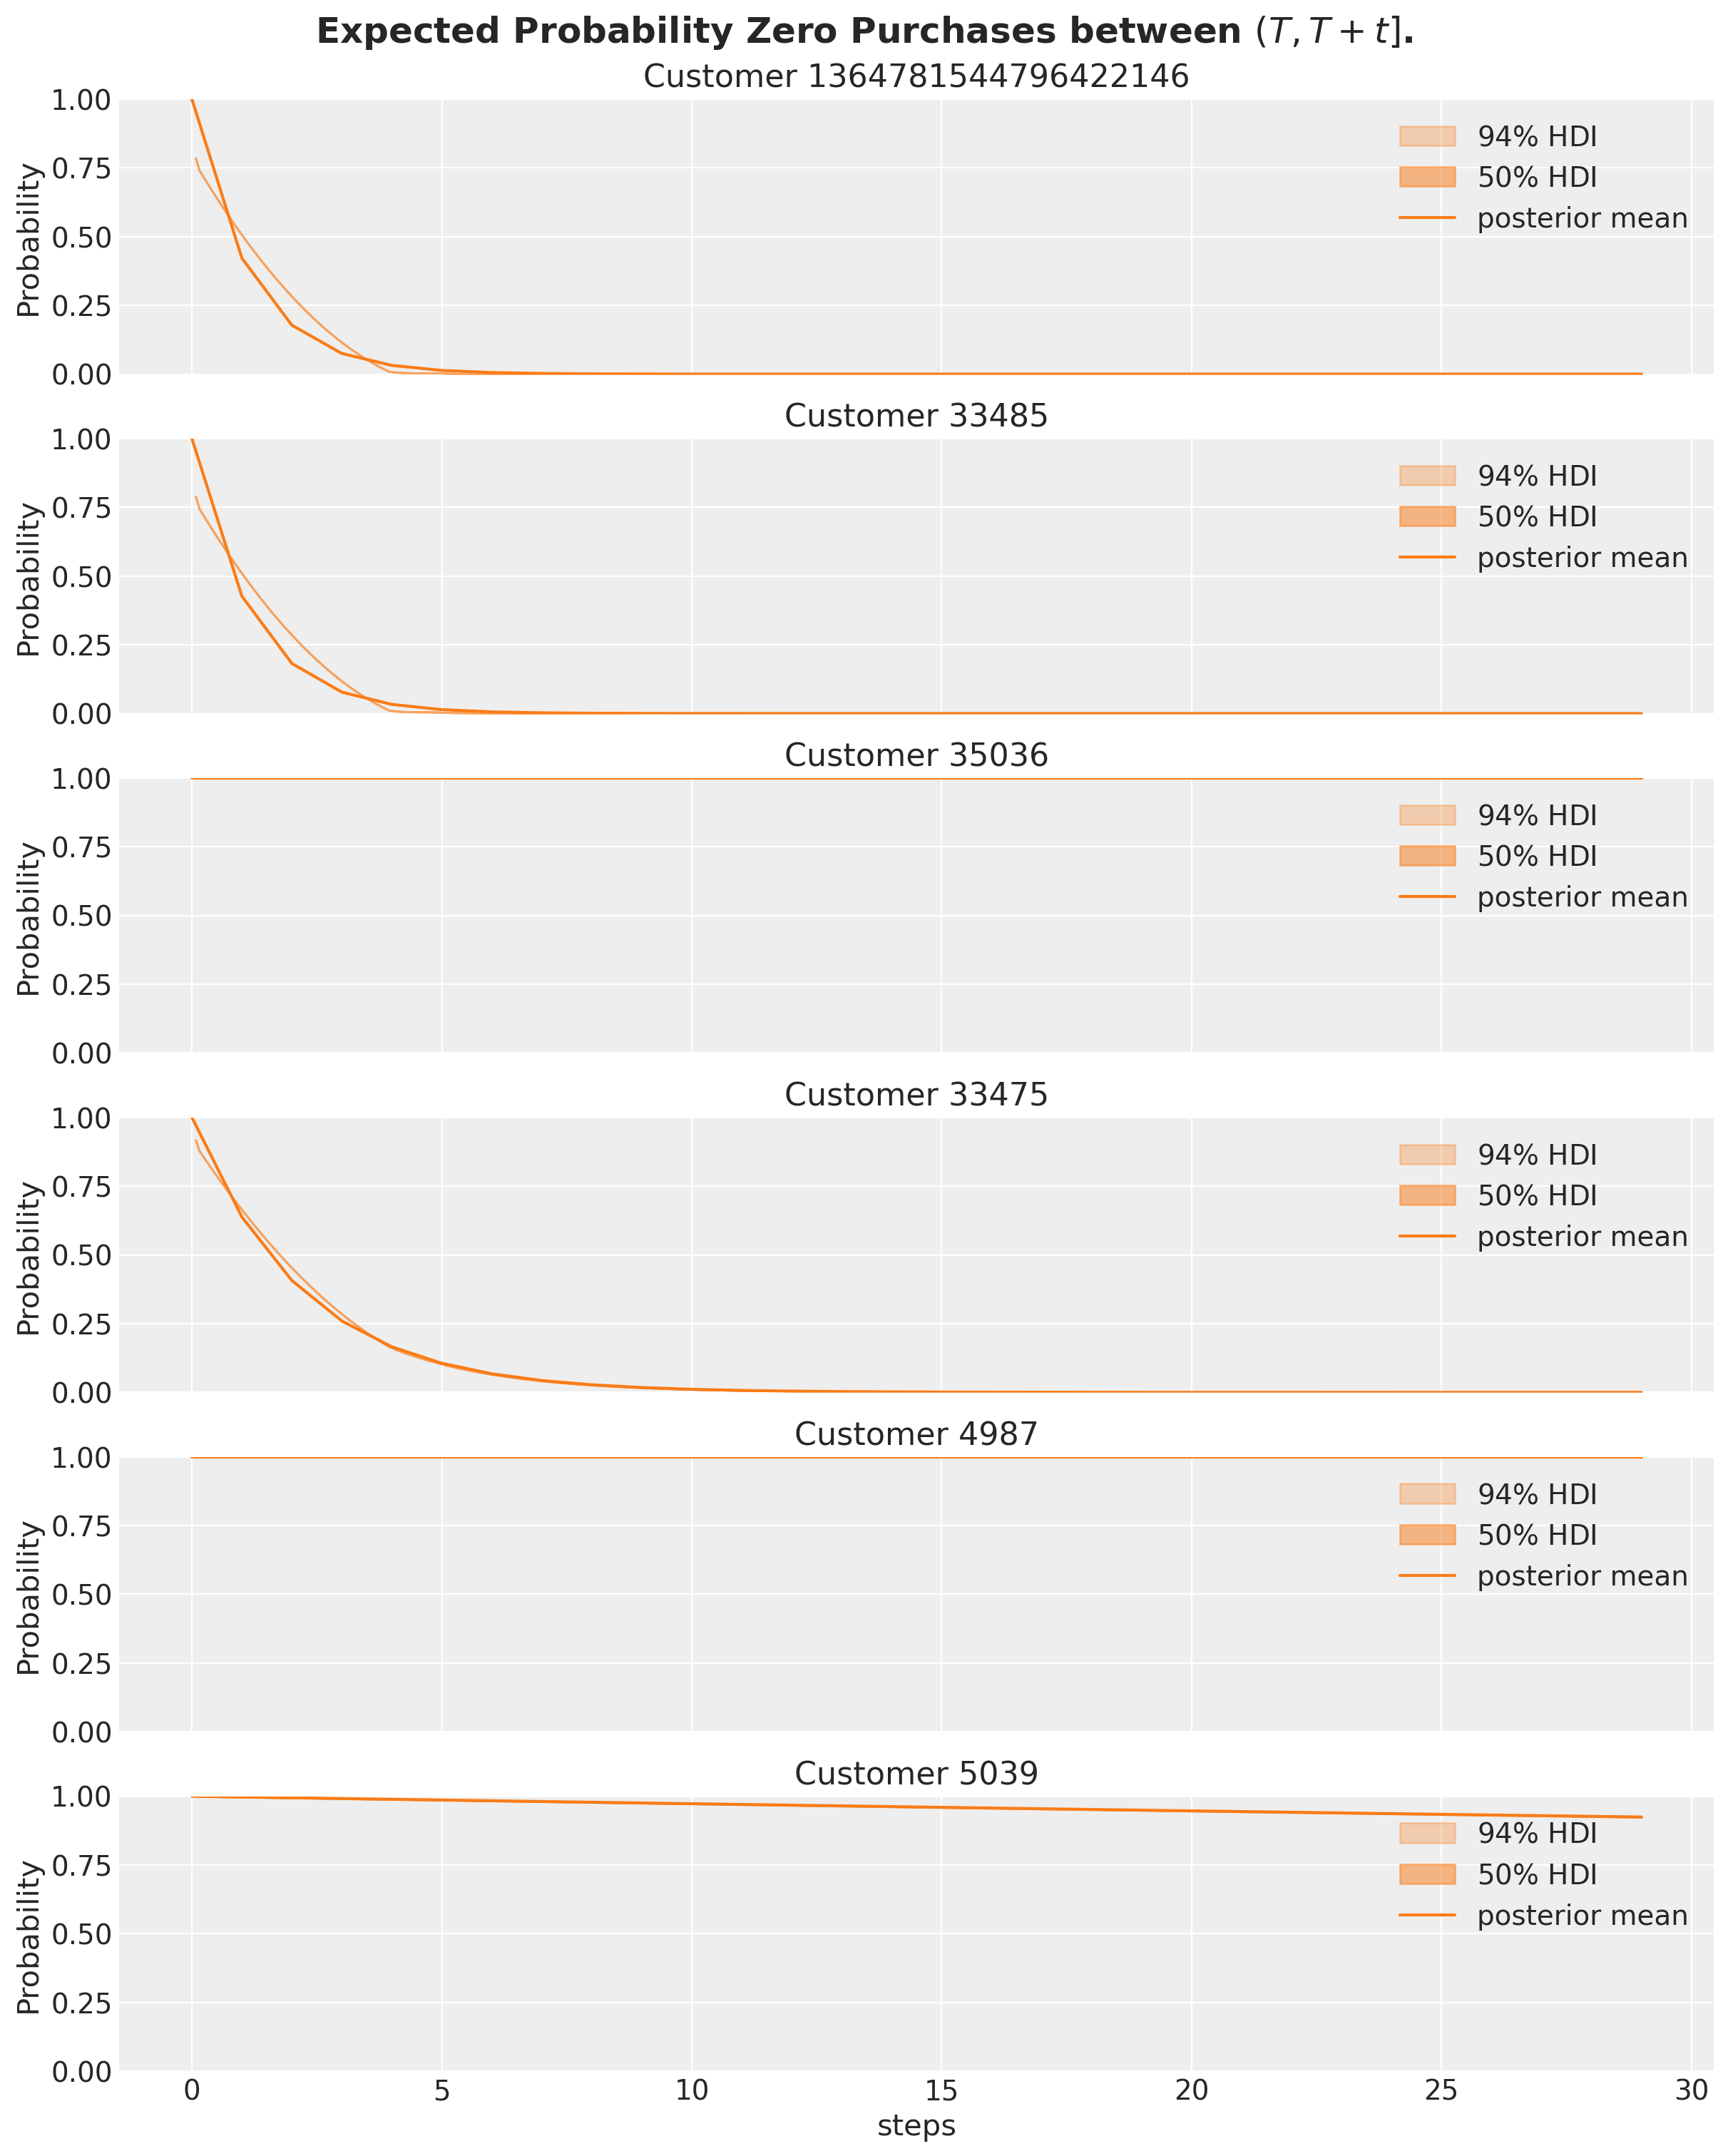

In [24]:
fig, axes = plt.subplots(
    nrows=len(example_customer_ids),
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    customer_expected_probability_zero_purchases = (
        expected_probability_zero_purchases.sel(customer_id=customer_id)
    )
    az.plot_hdi(
        range(steps),
        customer_expected_probability_zero_purchases,
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        range(steps),
        customer_expected_probability_zero_purchases,
        hdi_prob=0.5,
        color="C1",
        fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
        ax=ax,
    )
    ax.plot(
        range(steps),
        customer_expected_probability_zero_purchases.mean(dim=("chain", "draw")),
        color="C1",
        label="posterior mean",
    )
    ax.legend(loc="upper right")
    ax.set(title=f"Customer {customer_id}", ylabel="Probability", ylim=(0, 1))

axes[-1].set(xlabel="steps")
plt.gcf().suptitle(
    "Expected Probability Zero Purchases between $(T, T+t]$.",
    fontsize=18,
    fontweight="bold",
);